# CoRise Practice A/B Testing Course: Project 1

## Background
Welcome to **TinyTravelers**! We are essentially Airbnb for families with young kids. You recently joined as a product data scientist on a team focused on growing the number of homes on the platform. They are currently focused on improving the onboarding flow and have some ideas for improvements, but they need your help!

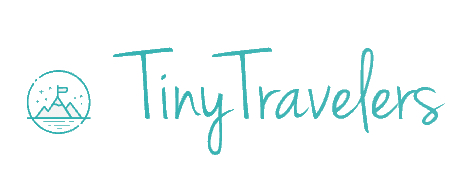

## Setup

**If you are running this in Colab**, you need to first load the data into Colab. If you are running this locally, you don't need to run the following block.

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1DsFtog7B0FuKLWzI_wSykjZ6nBApulbM/view?usp=share_link
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1tzKCnK1Z7LulNnLDbKKbmxPSyGoXZoUA/view?usp=share_link

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?id=1DsFtog7B0FuKLWzI_wSykjZ6nBApulbM
To: /content/dataset_autotitle.csv
100% 1.37M/1.37M [00:00<00:00, 46.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tzKCnK1Z7LulNnLDbKKbmxPSyGoXZoUA
To: /content/dataset_text_to_clicker.csv
100% 17.0M/17.0M [00:00<00:00, 128MB/s] 


Import libraries

In [ ]:
# Lirbary basics
import numpy as np
import pandas as pd
import scipy.stats as stats # For pvalue

Helper function to get the 95% confidence interval. Inputs:
* Mean treatment - average conversion rate of the treatment group
* Mean control - average conversion rate of the control group
* N treatment - number of samples in the treatment group
* N control - number of samples in the control group
* ci = The width of the confidence interval. 0.95 by default

You can read more about p-values and confidence intervals in this week's [module](https://corise.com/course/practical-ab-testing/v2/enrollment/enrollment_clfveg8uy01o712ecb49scfbz/module/module_clgh2w6oh01i412b4haan88ut).

In [ ]:
def get_ci(mean_treatment, mean_control, n_treatment, n_control, ci = 0.95):
    sd = ((mean_treatment * (1 - mean_treatment)) / n_treatment + (mean_control * (1 - mean_control)) / n_control)**0.5
    lift = mean_treatment - mean_control
    val = stats.norm.isf((1 - ci) / 2)
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    return((lwr_bnd, upr_bnd))

Helper function to calcuate the results. It will compute and return the relative and absolute lift between variant and control, p-value, and lower and upper bound for the 95% confidence interval. A standard two-sided t-test with an assumption of equal variance is used to compute the p-value.

Inputs:
* DF = data frame with each row being a sample in the A/B test. It must have a column called "variant" that takes on the value "control" or "treatment
* Metric = the metric we want to evaluate. This must be 'new_active_listings','new_booked_listings', or 'new_cancelled_listings'). If it is not one of these values an "invalid metric" error will be thrown.

In [ ]:
def calculate_results(df,metric):
    # Check
    if metric not in ('new_active_listing','new_booked_listing','new_cancelled_listing'):
        raise Exception("Invalid metric")
    
    # Values and relative difference
    mean_control = df.loc[df['variant'] == "control",metric].mean()
    mean_treatment = df.loc[df['variant'] == "treatment",metric].mean()
    
    abs_diff = mean_treatment-mean_control
    rel_diff = (mean_treatment-mean_control)/mean_control

    # P-Value -- two-sided ttest, assumes normal distribution 
    data_group1 = list(df.query('variant == "control"')[metric])
    data_group2 = list(df.query('variant == "treatment"')[metric])

    results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
    pvaue = results.pvalue

    # 95% confidence intervals 
    [ci_low, ci_high] = get_ci(mean_treatment,mean_control,len(data_group2),len(data_group1),.95)
    ci_low = ci_low/mean_control
    ci_high = ci_high/mean_control
    
    return(rel_diff,abs_diff,results.pvalue,ci_low,ci_high)

## Task 1: Identify the target and guardrail metrics

As discussed in the [course material](https://corise.com/course/practical-ab-testing/v2/module/module_clgh2w6oh01i412b4haan88ut#corise_clgqutzcl00053b71k5prvsv0), when running an A/B test, the decision to launch is dependent on whether a target metric is stat-sig positive assuming there is no detectable hit to the guardrail metrics. Picking the correct metric to measure in A/B test and inform these decision is critical. You can revisit the content from lecture [here](https://corise.com/course/practical-ab-testing/v2/enrollment/enrollment_clfveg8uy01o712ecb49scfbz/module/module_clgh2rpql01mj12e52bkmakp4). For convenience, considerations when determining the target metric for an A/B test are below:

1. *Sensitivity*. The lower the variance of the metric, the better you'll be able to detect small changes. Here the metrics are binary (0 or 1) so the closer to 0.5, the lower the variance will be.
2. *Timely*. Ideally the lag to measure the event tied to the metric is not too long.
3. *Business connection*. It is clear how optimizing the metric in an A/B test is connected to positive value and how success is meausured at the company level.

Since your team is focused on activation for hosts and are primarily focused on the onboarding flow, the new host user journey is the most relevant. The table below contains details about key steps in the journey, the percent that make it from one step to another, and how long it roughly takes to go from one step to another for those who do make it. For now you can assume each host only has one home (aka listing)

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | 40%                                | 40%                            | 2 hours                         |
| Home is booked by a guest            | 50%                                | 20%                            | 7 days                          |
| First guest stays at their home      | 90%                                | 18%                            | 14 days                         |
| Home receives the its first review   | 60%                                | 10.8%                          | 2 days                          |

Of the steps above, the most meaningful for the business is when the host receives their first review. This is important for both the demand (guests booking) and supply (hosts staying) side of the marketplace. When a listing is reviewed, it signals to a guest that this home is legit. You can imagine if you've never stayed at an Airbnb and the only option you see has no reviews, you might get scared and bring your business to a hotel instead. On the host side, receiving a review means you've already been paid, and is also positive (well, hopefully positive!) reinforcement that this hosting this is worth your time. However, as we noted above, A/B testing against new reviewed listings might not be feasiable. What metric should we use?

### Task 1.a. Pros and cons of each metric

Empowered with the information shared in the table above, you've narrowed it down to 3 possible metrics:

1. New active listings - when the home (listing) is published
2. New booked listings - when the listing is first booked by a gust
3. New reviewed listings - when the listing receives its first review


Please list the pros and cons for each. 

| ------------------- |

**New Active Listings**

Pros:

- Has a relatively high conversion rate to start with, so we won't need as many users in our test to detect a significant change
- Has a very short lag time, so we won't need to run our test for as long before we get results

Cons:

- Has a relatively weak connection to the outcomes the business cares about
- Optimizing for New Active Listings might result in onboarding many low-quality homes onto the platform

**New Booked Listings**

Pros:

- Still has a relatively high conversion rate (though not as high as New Active Listings), so we won't need as many users in our test to detect a significant change
- The lag time is manageable: you'll often see the first booking within a week of a listing coming online
- Closer to outcomes the business cares about. If a guest decides to book a newly-listed home, that provides some signal that the new listing is adding value to the platform

Cons:

- The turnaround time is still a week, which is a much longer time to wait than a few hours for New Active Listings
- Still not as close to business meaning as New Reviewed Listings

**New Reviewed Listings**

Pros:

- The metric most closely aligned with outcomes the business cares about

Cons:

- Has a very long lag time: for a typical new listing, you might have to wait 3+ weeks to get results
- Has a lower conversion rate from the start than the other potential metrics, so you'd need more users in your test to detect a significant change

| ------------------- |

#####**Hint**: Click to unhide

Remember, we need to balance practical considerations (how long will it take to get enough measurements?) with business considerations (if we optimize for the metric, will that get us closer to our actual goals?)"

### Task 1.b. Write which metric we should use and why

| ------------------- |

I'd suggest we use *New Booked Listings*, as it offers a reasonable balance between sensitivity (relatively high conversion rate), timeliness (you can expect results within a week or so), and business connection (if a guest makes a booking, that suggests the new listings are adding value).

| ------------------- |

### Task 1.c. List possible guardrail metrics 

As discussed in the [metrics module](https://corise.com/course/practical-ab-testing/v2/enrollment/enrollment_clfveg8uy01o712ecb49scfbz/module/module_clgh2rpql01mj12e52bkmakp4) this week, guardrail metrics are the measurements you wnat to track to ensure that the change is not having unintended consequences. Please list a few possible guardrail metrics - there are many right answers here.

| ------------------- |

There are many possible guardrail metrics. A few might include:

- **The conversion rate for New Active Listings.** For instance, maybe requiring hosts to provide more information about a listing during onboarding increases the new booking rate, but causes fewer hosts to finish the onboarding process. That may not be a trade-off we want to make.
- **Review scores for new bookings.** If any changes we make cause guests to leave reviews with lower scores, we'd probably want to know that.
- **Price for new bookings.** If any changes we make cause the typical booking price for new listings to change, we'd probably want to know that.

| ------------------- |

## Task 2: Design and analyze a test! Onboarding flow - auto-generate title

_**Warning**: This section gives away the answer to task 1, so please finish that first!_

After a discussion with PaM, we decided to use new booked listings (NBL) for the target metric and cancellations as our guardrail. We are also monitoring new active listings (NAL) to understand the impact on the funnel, but the impact on the metric won't matter for the decision or launch or not. 

The team is now ready to start measuring the impact of their ideas!

Part of the publish flow is to create the title for the listing. The title of a listing shows up in search when guests are looking for somewhere to stay, so it's important. But the team knows a lot of people get stuck here and abort the flow. So they came up with an idea to make it easier... enter ChatGPT! Instead of asking a guest to come up with their own title, a default title will be auto-generated leveraging the information already known about the home (e.g. location, amentities). The specific design change is below.

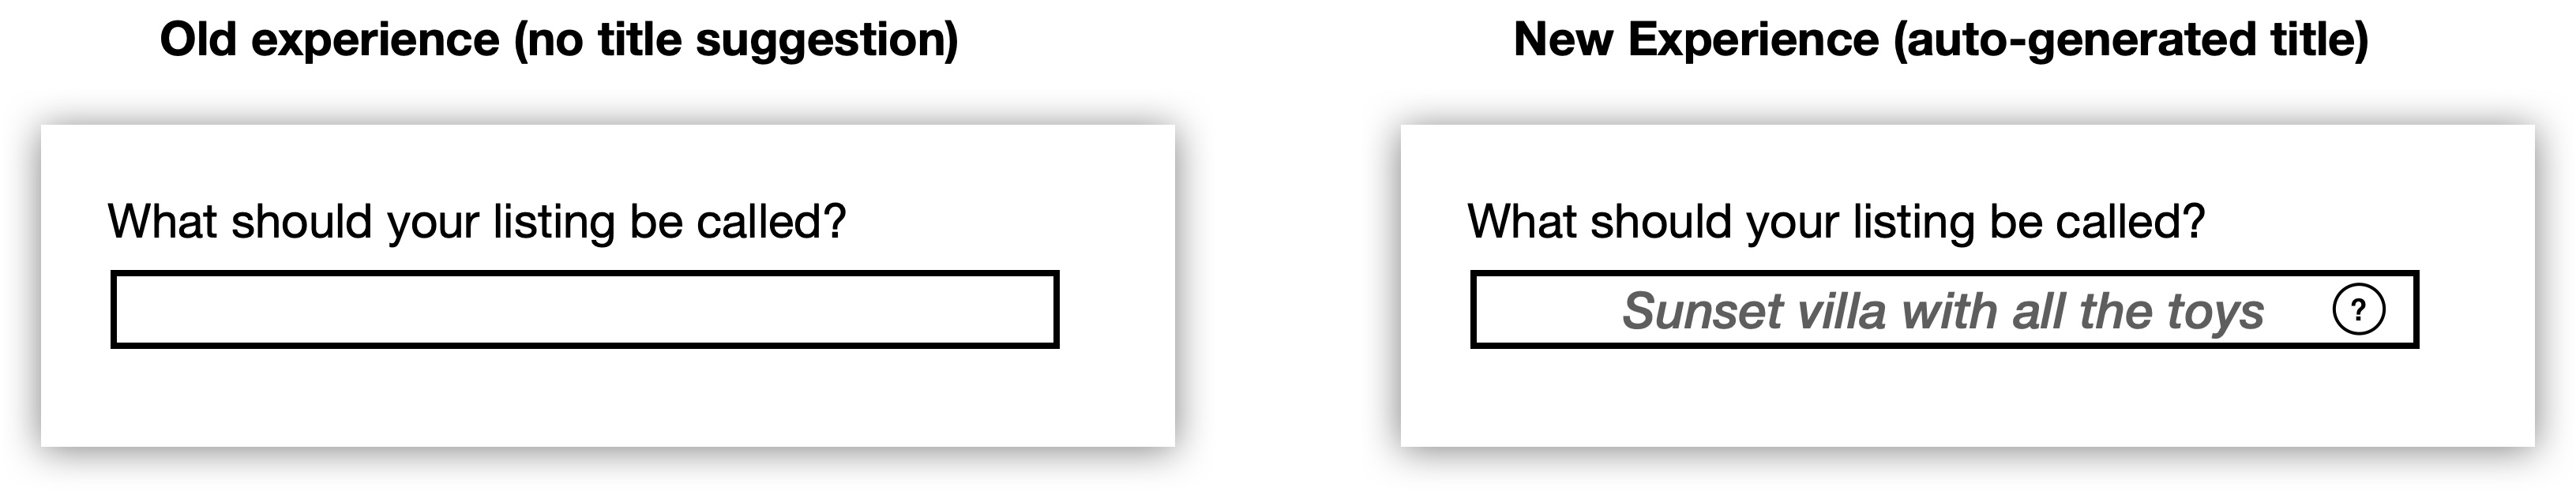

Due to the technical complexity of integrating with ChatGPT, we would need to see at least a _5% relative increase_ for this to be practically significant. Any smaller impact, even if positive, would not be worth it and we would choose not to launch.

### Task 2.a. Test design by answering the following...

#### Task 2.a.i. When should the test be triggered?

| ------------------- |

Ideally, users should be assigned to either the old experience (control) or new experience (test) as close to the proposed change in the product experience as possible. Here, that would mean users are assiged to see an auto-generated title or not immediately before they encounter the _What should your listing be called?_ box.

| ------------------- |

#### Task 2.a.ii. What is the hypothesis?

Note, as discussed the [test design module](https://corise.com/course/practical-ab-testing/v2/module/module_clgh2uhfk01mt12e52tqf4gmo#corise_clgpej5d700063b7125b1sdwy), we mean the hypothesis that takes on the form: "If we _product change_ it will increase _metric_, because _why you think that will happen_." You're welcome to write the null hypothesis as well but that's optional.



| ------------------- |

Here's an example of a hypothesis statement for this test:

_If we offer users an auto-generated title for their listing during the new listing publish flow, it will increase New Booked Listings, because the publish flow will be easier and fewer users will drop out._

It's also possible that the auto-generated titles are actually _better_ than the titles most users who finish publish flow would write themselves, which might also increase New Booked Listings.

The null hypothesis might look like this:

_If we offer users an auto-generated title for their listing during the new listing publish flow, there will be no impact on New Booked Listings._

| ------------------- |

#### Task 2.a.iii. How long should the test run and how will the launch/ no launch decision be made?

You can assume _5k_ new people hit the triggering point each day. Remember PaM had determined that she only cares about 5% or more impact. Use Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html) to do the power analysis. 

##### Hint below - click to unhide

This particular calcuator is commonly used on-the-job for quick power analysis of binary metrics. As discussed in the [test design module](https://corise.com/course/practical-ab-testing/v2/module/module_clgh2uhfk01mt12e52tqf4gmo#corise_clgpg1yqy000j3b712q0xi8wk), you determine run-time by first determining how many users you need for different impacts (minimal detectable effects) you care about. To use the calculator:

* Set the radio button to relative impact.
* Set the "baseline conversion rate" to the average rate in the population you're testing. Here you can assume 20% of the users will be booked so you can leave it at 0.20. 
* Adjust the minimal detectable effect to see how many users you need _per group_ (here you only need to check for 5% since that's the amount PaM is interested in detecting).
* Multiple the number of users needed by 2 since the traffic is split 50/50 for control and treatment.
* Estimate how long it will take to reach that sample size assuming 5K people enter the experiment each day.

| ------------------- |

Given a minimum detectable relevant effect of 5%, a baseline conversion rate of 20%, a significance level of 5%, and statistical power of 80%, we'll need 25,255 users per variant. Assuming a 50/50 split between control and treatment, that suggests we'll need at least 50,510 users in the experiment, total.

With 5,000 new users hitting the triggering point each day (that's a lot of new listings!), we'll need to run the experiment for at least 10 or 11 days to reach the required sample size.

That's only the amount of time require to get enough users in the experiment, though — not to get actual results! It will take time for these new listings to get their first booking (or not). We can typically expect half of these new listings to get booked within the first seven days, so we'll need to add at least seven days to the experiment.

In total, we might be looking at a minimum run time of 17-18 days.

We would make a decision to launch if there's a positive relative difference in New Booked Listings greater than 5%, and if the difference is statistically significant ($p<0.05$).

| ------------------- |

### Task 2.b. Test analysis
Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided. The data has already been cleaned for you. There is information for three milestones:

* new_active_listing - 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing - 1 if a user received a guest booked on a new listing during the experiment. Otherwise 0.
* new_cancelled_listing - 1 if a user cancelled a new booking during the experiment. Otherwise 0. 

_Basic_: What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) and do you recommend a launch or not based on that?

_Bonus_: Dig further to understand if the change was driven entirely by improving conversion through the onboarding flow without changing appeal (aka any change detected for new booked listing was entirely driven by a lift in new active listings) or might the bookability/ appeal change as well?

In [ ]:
df_autotitle = pd.read_csv('/content/dataset_autotitle.csv')

In [ ]:
results_nal = calculate_results(df_autotitle, 'new_active_listing')
results_nbl = calculate_results(df_autotitle, 'new_booked_listing')
results_ncl = calculate_results(df_autotitle, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,9.772540e-02,0.077658,0.027864
abs_diff,3.919286e-02,0.011297,0.000167
pvalue,2.441476e-24,0.000053,0.783098
ci_low,7.891850e-02,0.040017,-0.170508
ci_high,1.165323e-01,0.115299,0.226237


| ------------------- |

At a high level, these results strongly support the hypothesis that offering users auto-generated titles for their listings during the publishing flow increases New Booked Listings. Based on these findings, I would recommend we launch.

We observed a relative increase of about 7.8% in New Booked Listings, well above our threshold of a 5% relative increase for practical impact.

The results were statistically significant with a p-value of 0.00005. The 95% confidence interval suggests the true relative difference is very likely between 4% and 11.5%.

There was not a statistically significant difference in canceled listings between users who saw the auto-generated titles and users who did not.

| ------------------- |

In [ ]:
df_autotitle_published = df_autotitle.loc[df_autotitle['new_active_listing'] == 1]

In [ ]:
results_published_nbl = calculate_results(df_autotitle_published, 'new_booked_listing')

results_published = pd.DataFrame(
    {
        'new_booked_listing': results_published_nbl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results_published

,new_booked_listing
rel_diff,-0.018281
abs_diff,-0.006631
pvalue,0.251133
ci_low,-0.049507
ci_high,0.012945


| ------------------- |

It looks like the difference was driven primarily by improving the conversion rate of the new listing publishing flow. Assuming a user finished the new listing publishing flow, there was not a statistically significant difference in New Booked Listings.

We can test this by first filtering the data to only include users who finished the onboarding flow and published their listings (`'new_active_listing'==1`) and re-running the statistical tests. After filtering the data in this way, there may have been a modest decline in New Booked Listings (relative difference = -1.8%) but the results were not statistically significant ($p=0.25$).

| ------------------- |

### What happened?
_**Warning**: this will give away the answer to the previous task._

You brought your findings to PaM and the team and they were SO excited to see the impact of this change. It is clearly indicated that suggesting a title helped some stuck hosts-to-be get unstuck and the impact was well worth the cost of the technical integration. The change was launched to 100% with a pop of chatGPT champagne.

## Task 3: Design and analyze another test! Onboarding flow - free text to clicker

One step in the onboarding flow is to change the guest details UI. The team believes that having a default and clicking to adjust will be less friction than typing.

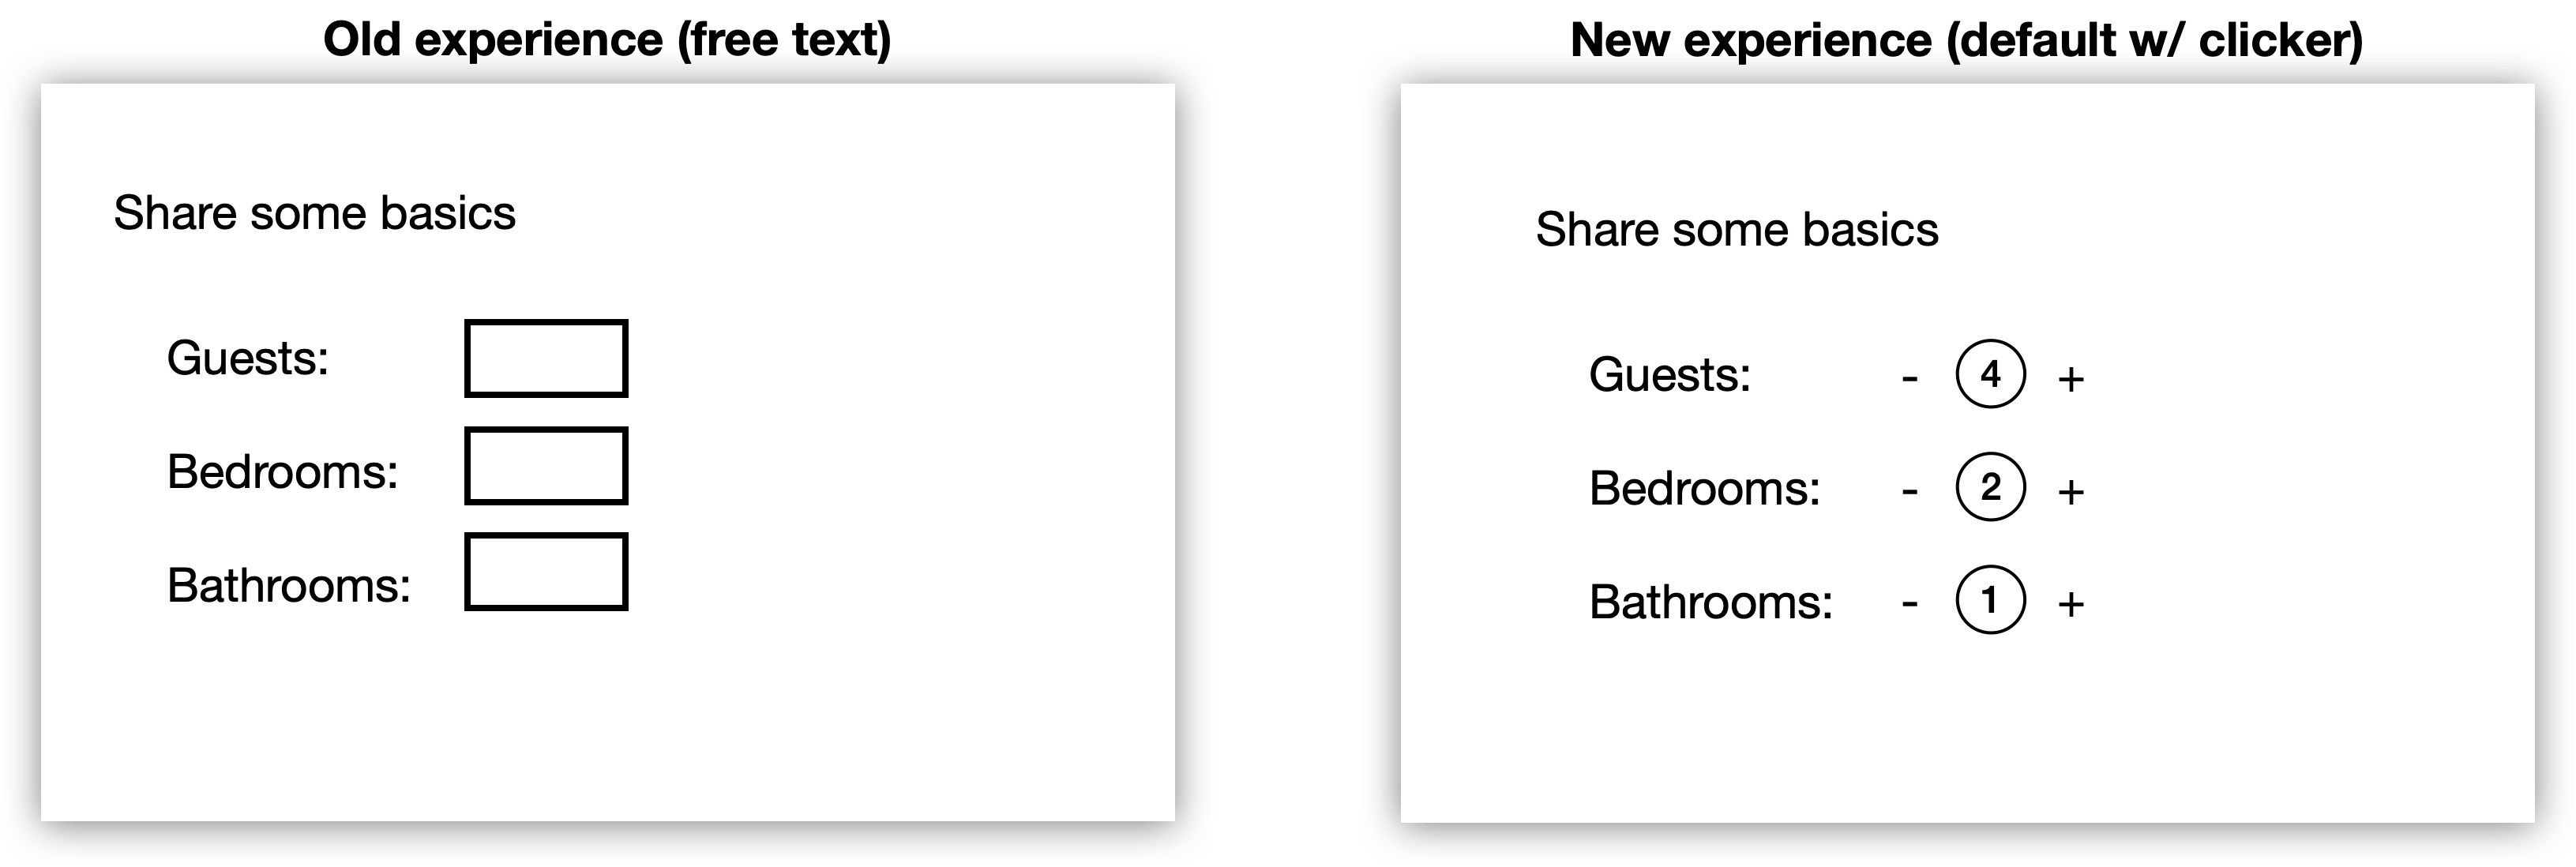

### Task 3.a. Test design by answering the following...

#### Task 3.a.i. When should the test be triggered?

| ------------------- |

Ideally, users should be assigned to either the old experience (empty free text boxes) or new experience (default values with clickers) as close to the proposed change in the product experience as possible. Here, that would mean users are assiged to see either the old experience or new experience immediately before they encounter the _Share some basics_ section of the onboarding flow.

| ------------------- |

#### Task 3.a.ii. What is the hypothesis?

| ------------------- |

You might phrase the hypothesis like this:

_If we offer users a default value with clickers to make adjustments instead of empty free text boxes to share details about Guests, Bedrooms, and Bathrooms, New Booked Listings will increase, because the change will reduce friction in the onboarding flow for new listings and fewer users will drop out._

| ------------------- |

#### Task 3.a.iii. How long should the test run and how will the launch/ no launch decision be made?

In this case PaM does care about detecting smaller changes and wants to be in position to capture a _2% relative increase_ if it exists. This change isn't blocking other planned work, so she is OK if we need to run it for up to 8 weeks. Of course, if we can detect a 2% change in fewer than 8 weeks that would be great. Fortunately there are more visitors to this page at the time this test is run, so you can assume _10K_ hit the triggering point each day.

| ------------------- |

Given a minimum detectable relevant effect of 2%, a baseline conversion rate of 20%, a significance level of 5%, and statistical power of 80%, we'll need 157,328 users per variant. Assuming a 50/50 split between control and treatment, that suggests we'll need at least 314,656 users in the experiment, total.

With 10,000 new users hitting the triggering point each day, we'll need to run the experiment for about 31 or 32 days to reach the required sample size.

That's only the amount of time require to get enough users in the experiment, though — not to get actual results! It will take time for these new listings to get their first booking (or not). We can typically expect half of these new listings to get booked within the first seven days, so we'll need to add at least seven days to the experiment.

In total, we might be looking at a minimum run time if 38-39 days. That's about 5.5 weeks, less than our 8-week requirement.

In this scenario, we would launch if the test shows a relative difference in New Booked Listings of at least +2%, and the results are statistically significant ($p<0.05$).

| ------------------- |

### Task 3.b. Test analysis
Please analyze the test and summarize the learnings and recommendations for PaM and the team below. The has already been cleaned for you.. There is information for three milestones:

* new_active_listing - 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing - 1 if a user received a guest booked on a new listing during the experiment. Otherwise 0.
* new_cancelled_listing - 1 if a user cancelled a new booking during the experiment. Otherwise 0. 

What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) and do you recommend a launch or not based on that? No bonus on this one.

In [ ]:
df_text_to_clicker = pd.read_csv('/content/dataset_text_to_clicker.csv')

results_nal = calculate_results(df_text_to_clicker, 'new_active_listing')
results_nbl = calculate_results(df_text_to_clicker, 'new_booked_listing')
results_ncl = calculate_results(df_text_to_clicker, 'new_cancelled_listing')

results = pd.DataFrame(
    {
        'new_active_listing': results_nal,
        'new_booked_listing': results_nbl,
        'new_canceled_listing': results_ncl,
    },
    index=['rel_diff','abs_diff','pvalue','ci_low','ci_high']
)

results

,new_active_listing,new_booked_listing,new_canceled_listing
rel_diff,0.001638,0.001814,0.029988
abs_diff,0.000651,0.000150,0.000076
pvalue,0.707029,0.877756,0.671322
ci_low,-0.006904,-0.021300,-0.108522
ci_high,0.010181,0.024928,0.168498


| ------------------- |

The test results suggest changing the empty free text boxes to default values with clickers had no meaningful impact on our target metric, New Booked Listings, or our guardrail metric, New Canceled Listings.

For both metrics, the p-value was high (0.88 and 0.67, respectively) and the 95% confidence interval is roughly centered around 0.

Unless there are other reasons to keep the clickers, the test results suggest we should cancel the launch.

| ------------------- |

### What happened?

_**Warning**: this will give away the answer to the previous task._

You brought the summary to PaM and the team. They were a bit disappointed their idea didn't pan out but understand not everything can work, and they were still happy from the auto-title change topped with champagne. So they rolled back the change and deleted the code supporting the clickers. Onward!

## Bonus. 

### How might A/B testing in the onboarding flow violate SUTVA?

As a reminder, SUTVA implies that you can assume what treatment applies to the variant does not impact control. 

| ------------------- |

If we choose New Booked Listings as our target metric, then guests looking to make bookings become a "shared resource" between the variant and control groups. In other words, listings in the variant and control groups are competing for bookings among the same population of potential guests. This could be a SUTVA violation.

For instance, let's say the listing titles auto-generated by ChatGPT actually _had_ made listings more appealing to prospective guests. In this case, each time a guest books a listing in the treatment group, that's one fewer guest available to book a listing in the control group. This could lead to exaggerated estimates of the relative difference / effect size between treatment and control.

| ------------------- |